In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
import textblob as tb

nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/peterclark/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/peterclark/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/peterclark/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
## ML Imports #
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import mean_squared_error, roc_auc_score, log_loss, f1_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.inspection import permutation_importance


In [5]:
STOPWORDS = set(stopwords.words('english'))
def preprocess_text(text):
    if pd.isna(text):
        return ""

    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w not in STOPWORDS]

    return ' '.join(tokens)

def split_ticket(ticket):
        try:
            parts = str(ticket).split('/')
            # Returns (TicketType, TicketClass)
            # Example: 'CB/734/XL' -> 'CB', 'XL'
            return parts[0], int(parts[1]), parts[2]
        except:
            return None, None, None

def split_id(id):
    try:
        parts = str(id).split('/')
        return parts[0], parts[1]
    except:
        return 0,0

sia=SentimentIntensityAnalyzer()
def vader_polarity(text):
    if not isinstance(text, str) or text.strip() == "":
        return 0.0
    return sia.polarity_scores(text)["compound"]


def preprocess_csv(path, save=False, filename=""):
    data = pd.read_csv(path)

    # Fill NaNs #
    # Numerical Columns with Median #
    print(f"Missing values: {data.isnull().sum().sum()}")
    print(f"Missing values in Age: {data['Age'].isnull().sum()}") 
    print(f"Missing values in AvgTime: {data['AvgTime'].isnull().sum()}") 
    
    # Categorical Columns with Mode#
    print(f"Missing values in Concert: {data['Concert'].isnull().sum()}")
    print(f"Missing values in TicketInfo: {data['TicketInfo'].isnull().sum()}")
    print(f"Missing values in PreferedAlbum: {data['PreferedAlbum'].isnull().sum()}")
    print(f"Missing values in Vinyl: {data['Vinyl'].isnull().sum()}")
    print(f"Missing values in VIP: {data['VIP'].isnull().sum()}")
    
    data=data.dropna(subset=['Concert', 'TicketInfo', 'PreferedAlbum', 'Vinyl','VIP','Opinion'])

    data['Age'] = data['Age'].fillna(data['Age'].median())
    data['isAdult'] = data['Age'] >= 18

    cat_cols = ['Concert', 'PreferedAlbum', 'Vinyl', 'VIP']
    for col in cat_cols:
        # Mode returns a series, we take the first element [0]
        data[col] = data[col].fillna(data[col].mode()[0])
  
    data['consumeF'] = data['Food'] > 0.0
    data['consumeD'] = data['Drinks'] > 0.0

    data['logDrinks']=np.log1p(data['Drinks'])
    data['logFood']=np.log1p(data['Food'])

    data['FoodRate'] = data['logFood'] / data['AvgTime']
    data['DrinkRate'] = data['logDrinks'] / data['AvgTime']

    data[['FoodRate', 'DrinkRate']] = (
        data[['FoodRate', 'DrinkRate']]
        .replace([np.inf, -np.inf], np.nan)
        .fillna(0.0)
    )

    # Rates may be a better indicator of habits
    #data=data.drop(columns=['Drinks', 'Food'])

    data["Opinion_Polarity"] = (data["Opinion"].apply(preprocess_text).apply(vader_polarity))
    data['Concert_City'] = data['Concert'].astype(str).str.extract(r'^([A-Za-z]+)') # concert city 
    data['Concert_StartTime'] = data['Concert'].astype(str).str.extract(r'([A-Za-z]+)(\d+)-', expand=False)[1].astype(float) # Extract end time (the number after the dash, before 'pm')
    data['Concert_EndTime'] = data['Concert'].astype(str).str.extract(r'-(\d+)pm').astype(float)
    data['Concert_Duration'] = 12+data['Concert_EndTime'] - data['Concert_StartTime']
    
    # Only concert length of interest
    data = data.drop(columns=['Concert', 'Concert_StartTime', 'Concert_EndTime'])
    
    # Apply function and create 3 new columns
    data[['Ticket_Type', 'Ticket_Num', 'Ticket_Class']] = data['TicketInfo'].apply(
        lambda x: pd.Series(split_ticket(x))
    )
    
    
    
    # Create dummy variables (One-Hot Encoding)
    # drop_first=True avoids multicollinearity (e.g., if not Male, then Female)
    #still_not_number_cols = ['PreferedAlbum', 'Vinyl', 'VIP', 'Concert_City','Ticket_Class']
    #df_encoded = pd.get_dummies(data, columns=still_not_number_cols, drop_first=True)
    df_final = data.drop(columns=['Opinion', 'TicketInfo']) # drop processed columns
    #print(f"Still missing values:\n{df_final.isnull().sum()}")
    if save:
        df_final.to_csv(filename, index=False)

    return df_final

In [ ]:
## CATEGORICAL DATA PREPROCESSING ##
STOPWORDS = set(stopwords.words('english'))

def preprocess_csv_cat(path, save=False, filename=""):
    # 1. Load data
    data = pd.read_csv(path)

    # 2. Fill missing Age and create isAdult
    data["Age"] = data["Age"].fillna(data["Age"].median())
    data["isAdult"] = data["Age"] >= 18

    # 3. Create consumption flags and log features
    data["consumeF"] = data["Food"] > 0.0
    data["consumeD"] = data["Drinks"] > 0.0
    data["logDrinks"] = np.log1p(data["Drinks"])
    data["logFood"] = np.log1p(data["Food"])

    # 4. Compute Opinion polarity
    data["Opinion_Polarity"] = data["Opinion"].apply(preprocess_text).apply(vader_polarity)

    # 5. Fill missing categorical columns
    cat_cols = ['PreferedAlbum', 'Vinyl', 'VIP']
    for col in cat_cols:
        data[col] = data[col].fillna(data[col].mode()[0])

    # --- Concert-specific handling ---
    # 6. Fill missing Concert values
    def fill_concert(row):
        if pd.notna(row["Concert"]):
            return row["Concert"]
        
        for _,city in enumerate(["NYC", "SF", "FL"]):
            if city in str(row["Opinion"]):
                t_concert=["12_5PM","14_7PM","16-7PM"]
                return city+t_concert[_]
        # If no info, fill with mode
        return data["Concert"].mode()[0]

    data["Concert"] = data.apply(fill_concert, axis=1)

    # 7. Extract Concert info
    data["Concert_City"] = data["Concert"].astype(str).str.extract(r"^([A-Za-z]+)")

    # Extract start and end time if present
    data["Concert_StartTime"] = (
        data["Concert"].astype(str).str.extract(r"([A-Za-z]+)(\d+)-", expand=False)[1].astype(float)
    )
    data["Concert_EndTime"] = (
        data["Concert"].astype(str).str.extract(r"-(\d+)pm").astype(float)
    )
    data["Concert_Duration"] = 12 + data["Concert_EndTime"] - data["Concert_StartTime"]

    # Drop intermediate columns
    data = data.drop(columns=["Concert", "Concert_StartTime", "Concert_EndTime"])

    ticket_letters = ['A', 'B', 'CB', 'CB','LB','LT','RT', 'PB','RB']
    ticket_letters_p = [0.092626,0.108936,0.293495,0.003658, 0.328885, 0.087683, 0.004053, 0.026196, 0.054468]
    ticket_classes = ['N', 'XL']  # adjust based on your data

    # Function to create a random ticket
    def generate_ticket():
        letter = np.random.choice(ticket_letters,p=ticket_letters_p)
        number = f"{np.random.randint(0, 9999):04d}"  # four-digit with leading zeros
        tclass = np.random.choice(ticket_classes,p=[0.50,0.50])
        return f"{letter}/{number}/{tclass}"
    def fill_ticket(row):
        if pd.notna(row["TicketInfo"]):
            return row["TicketInfo"]
        # Generate a ticket if missing
        return generate_ticket()

    data["TicketInfo"] = data.apply(fill_ticket, axis=1)

    # 9. Split TicketInfo into separate columns
    data[["Ticket_Type", "Ticket_Num", "Ticket_Class"]] = data["TicketInfo"].apply(
        lambda x: pd.Series(split_ticket(x))
    )

    # 10. Encode categorical columns
    categorical_cols = [
        "PreferedAlbum", "Vinyl", "VIP", "Concert_City", "Ticket_Type", "Ticket_Class"
    ]
    
    print(data['Ticket_Type'].value_counts(normalize=True))
    print(data['Ticket_Class'].value_counts(normalize=True))
    categorical_features = []
    for col in categorical_cols:
        if col in data.columns:
            data[col] = data[col].astype("category").cat.codes
            categorical_features.append(col)


    df_final = data.drop(columns=["Opinion", "TicketInfo"])

    cat_feature_idx = [
        df_final.columns.get_loc(c)
        for c in categorical_features
        if c in df_final.columns
    ]

    if save:
        df_final.to_csv(filename, index=False)

    return df_final, cat_feature_idx


In [7]:
path = os.getcwd()
data=preprocess_csv(path+'/train.csv', save=False, filename=path+'/train_cleaned.csv')
data_cat, data_cat_idx=preprocess_csv_cat(path+'/train.csv', save=False, filename=path+'/train_cleaned.csv')
data.columns

Missing values: 2885
Missing values in Age: 216
Missing values in AvgTime: 0
Missing values in Concert: 216
Missing values in TicketInfo: 231
Missing values in PreferedAlbum: 235
Missing values in Vinyl: 249
Missing values in VIP: 235
LB    0.332345
CB    0.297450
B     0.106860
A     0.092428
LT    0.087189
PB    0.055259
RB    0.027679
RT    0.000791
Name: Ticket_Type, dtype: float64
XL    0.505931
N     0.494069
Name: Ticket_Class, dtype: float64


Index(['Id', 'PreferedAlbum', 'Vinyl', 'AvgTime', 'Age', 'VIP', 'Food',
       'Drinks', 'FreePass', 'isAdult', 'consumeF', 'consumeD', 'logDrinks',
       'logFood', 'FoodRate', 'DrinkRate', 'Opinion_Polarity', 'Concert_City',
       'Concert_Duration', 'Ticket_Type', 'Ticket_Num', 'Ticket_Class'],
      dtype='object')

In [8]:
path = os.getcwd()
data_test = preprocess_csv(path+"/test.csv", save=True, filename=path+"/test_cleaned.csv")
data_test_cat, data_test_cat_idx=preprocess_csv_cat(path+'/test.csv', save=False, filename=path+'/test_cleaned.csv')
data_test.head()

Missing values: 767
Missing values in Age: 54
Missing values in AvgTime: 0
Missing values in Concert: 58
Missing values in TicketInfo: 68
Missing values in PreferedAlbum: 53
Missing values in Vinyl: 61
Missing values in VIP: 61
LB    0.338472
CB    0.300280
B     0.096356
LT    0.088998
A     0.082341
PB    0.059215
RB    0.033287
RT    0.001051
Name: Ticket_Type, dtype: float64
N     0.507358
XL    0.492642
Name: Ticket_Class, dtype: float64


,Id,PreferedAlbum,Vinyl,AvgTime,Age,VIP,Food,Drinks,isAdult,consumeF,...,logDrinks,logFood,FoodRate,DrinkRate,Opinion_Polarity,Concert_City,Concert_Duration,Ticket_Type,Ticket_Num,Ticket_Class
1,01/6673,Head Hunters,False,1.481,45.0,False,1595.0,13.0,True,True,...,2.639057,7.375256,4.979916,1.781943,0.5994,NYC,5.0,B,425,N
2,02/0337,Bright Size Life,False,1.385,19.0,False,1400.0,1060.0,True,True,...,6.966967,7.244942,5.231005,5.030301,-0.2023,NYC,5.0,LB,63,XL
3,01/6655,Bright Size Life,True,1.894,30.0,False,0.0,0.0,True,False,...,0.000000,0.000000,0.000000,0.000000,0.5719,NYC,5.0,B,422,N
4,01/4723,Head Hunters,False,2.102,17.0,False,262.0,502.0,False,True,...,6.220590,5.572154,2.650882,2.959367,0.0000,FL,3.0,LB,888,XL
5,01/3175,Kind of Blue,True,1.763,38.0,False,0.0,0.0,True,False,...,0.000000,0.000000,0.000000,0.000000,0.3400,FL,3.0,A,104,N


<Axes: xlabel='duration_diff', ylabel='Count'>

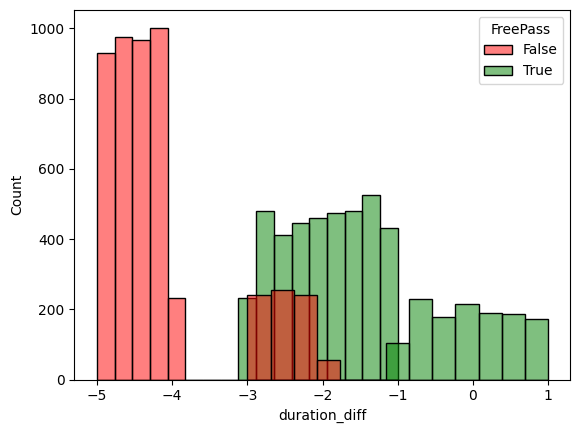

In [102]:
data = data.assign(
    duration_diff=data['AvgTime']-data['Concert_Duration']
)

sns.histplot(
    data=data.loc[data['Concert_Duration'] > 4],
    x='duration_diff',
    hue='FreePass',
    palette=['red','green']
)
sns.histplot(
    data=data.loc[data['Concert_Duration'] < 4],
    x='duration_diff',
    hue='FreePass',
    palette=['red','green']
)



In [354]:
data['consume']

0         True
1        False
2         True
3         True
4         True
         ...  
10110     True
10111     True
10113     True
10114     True
10115     True
Name: consume, Length: 9003, dtype: bool

<Axes: xlabel='Ticket_Num', ylabel='Count'>

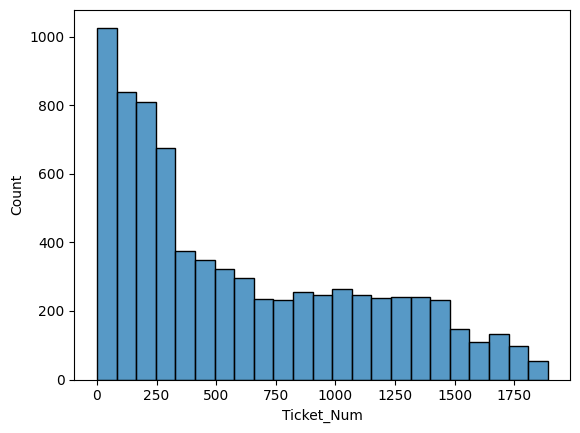

In [81]:
sns.histplot(data, x='Ticket_Num')

/var/folders/_m/vj49vq3972b166bph370j1kw0000gn/T/ipykernel_45139/1783800525.py:84: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


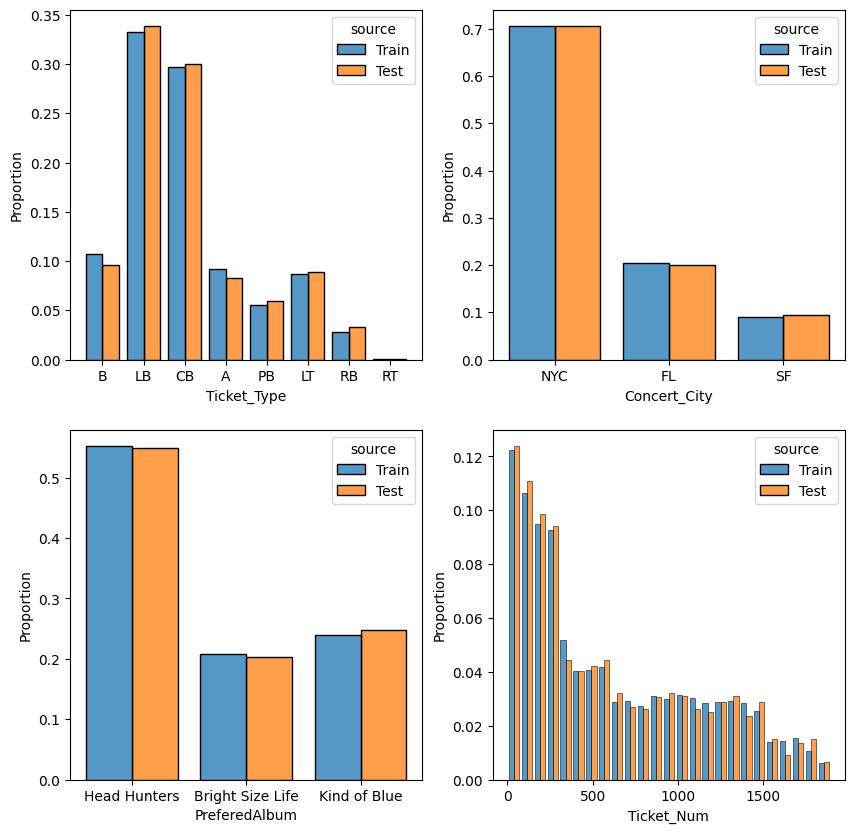

In [86]:
fig,((one,two),(three,four)) = plt.subplots(2,2, sharex=False, sharey=False, figsize=(10,10))
#-- Ticket Types
ticket_labels = data['Ticket_Type'].astype('category').cat.categories
data_cat_plot = data_cat.copy()
data_cat_test_plot = data_test_cat.copy()

data_cat_plot['Ticket_Type'] = data_cat_plot['Ticket_Type'].map(dict(enumerate(ticket_labels)))
data_cat_test_plot['Ticket_Type'] = data_cat_test_plot['Ticket_Type'].map(dict(enumerate(ticket_labels)))

plot_df = pd.concat([data_cat_plot[['Ticket_Type']].assign(source='Train'), data_cat_test_plot[['Ticket_Type']].assign(source='Test')], ignore_index=True)

#--- Concert City
city_labels = data['Concert_City'].astype('category').cat.categories
data_cat_plot = data_cat.copy()
data_cat_test_plot = data_test_cat.copy()

data_cat_plot['Concert_City'] = data_cat_plot['Concert_City'].map(dict(enumerate(city_labels)))
data_cat_test_plot['Concert_City'] = data_cat_test_plot['Concert_City'].map(dict(enumerate(city_labels)))
plot_df2 = pd.concat([data_cat_plot[['Concert_City']].assign(source='Train'), data_cat_test_plot[['Concert_City']].assign(source='Test')], ignore_index=True)

#--- Album
album_labels = data['PreferedAlbum'].astype('category').cat.categories
data_cat_plot = data_cat.copy()
data_cat_test_plot = data_test_cat.copy()

data_cat_plot['PreferedAlbum'] = data_cat_plot['PreferedAlbum'].map(dict(enumerate(album_labels)))
data_cat_test_plot['PreferedAlbum'] = data_cat_test_plot['PreferedAlbum'].map(dict(enumerate(album_labels)))
plot_df3 = pd.concat([data_cat_plot[['PreferedAlbum']].assign(source='Train'), data_cat_test_plot[['PreferedAlbum']].assign(source='Test')], ignore_index=True)

#--- Ticket Numbers
data_cat_plot = data.copy()
data_cat_test_plot = data_test.copy()
plot_df4 = pd.concat([data_cat_plot[['Ticket_Num']].assign(source='Train'), data_cat_test_plot[['Ticket_Num']].assign(source='Test')], ignore_index=True)

sns.histplot(
    data=plot_df,
    x='Ticket_Type',
    hue='source',
    discrete=True,
    multiple='dodge',
    shrink=0.8,
    stat='proportion',
    common_norm=False,
    ax=one
)

sns.histplot(
    data=plot_df2,
    x='Concert_City',
    hue='source',
    discrete=True,
    multiple='dodge',
    shrink=0.8,
    stat='proportion',
    common_norm=False,
    ax=two
)

sns.histplot(
    data=plot_df3,
    x='PreferedAlbum',
    hue='source',
    discrete=True,
    multiple='dodge',
    shrink=0.8,
    stat='proportion',
    common_norm=False,
    ax=three
)
sns.histplot(
    data=plot_df4,
    x='Ticket_Num',
    hue='source',
    multiple='dodge',
    shrink=0.8,
    stat='proportion',
    common_norm=False,
    ax=four
)
#sns.JointGrid(one, two, three, four)
#one.set_xlabel('Ticket Type')
#one.set_ylabel('Count')
#one.set_title('Ticket Type Distribution')
fig.show()

<Axes: xlabel='Ticket_Type', ylabel='Proportion'>

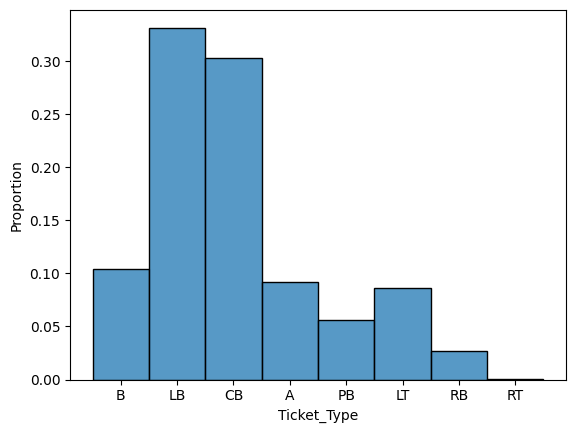

In [32]:
sns.histplot(data, x='Ticket_Type', stat='proportion', multiple='dodge')


<Axes: xlabel='Ticket_Type', ylabel='Count'>

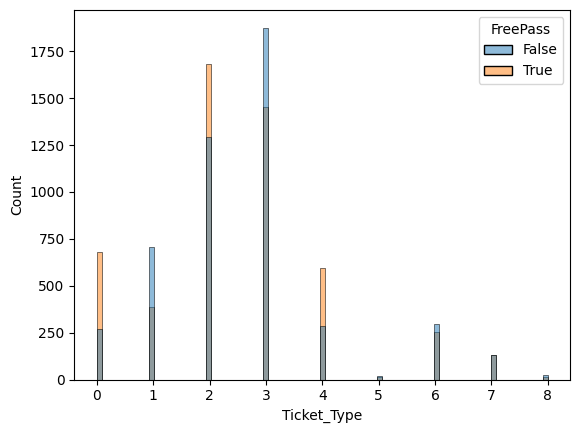

In [184]:
sns.histplot(data=data_cat, x='Ticket_Type',hue='FreePass')

In [341]:
mu=data['AvgTime'].mean()
data['t_adj']=np.where(
    data['AvgTime']>mu,
    data['AvgTime'], #bigger
    mu-data['AvgTime'] )#smaller

<Axes: xlabel='logDrinks', ylabel='Count'>

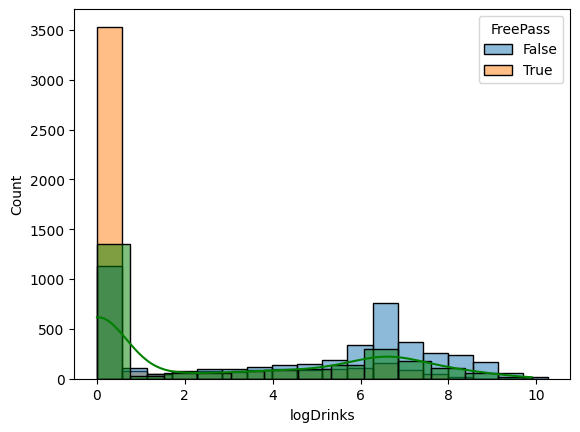

In [384]:
sns.histplot(data, x=data['logDrinks'], hue='FreePass')
#sns.histplot(data, x=data['AvgTime']/data['logFood'],kde=True, hue='FreePass')
#sns.histplot(data_test, x=data_test['AvgTime'],kde=True,color='green',alpha=0.5)
sns.histplot(data_test, x=data_test['logDrinks'], kde=True, color=['green'])


In [ ]:
pca_data_pre = data.drop(columns=['Id','FreePass']).copy()
pca_data_scaled = StandardScaler().fit_transform(pca_data_pre)
pca=PCA()
pca_data = pca.fit_transform(pca_data_scaled)

explained = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(6, 4))
plt.plot(explained, marker='o')
plt.axhline(0.80, color='black', linestyle='--', linewidth=1)
plt.axhline(0.90, color='black', linestyle=':', linewidth=1)
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.tight_layout()
plt.show()

In [36]:
loadings = pd.DataFrame(
    pca.components_.T,
    index=pca_data_pre.columns,
    columns=[f"PC{i+1}" for i in range(pca_data_pre.shape[1])]
)

loadings.iloc[:, :4].sort_values("PC1", key=abs, ascending=False).head(10)


,PC1,PC2,PC3,PC4
Ticket_Type_CB,-0.354543,0.017433,0.140069,-0.404881
logFood,0.348535,0.302091,-0.090948,-0.095040
logDrinks,0.348029,0.249906,-0.015649,-0.194812
PreferedAlbum_Kind of Blue,0.309188,-0.384441,0.055864,-0.020358
PreferedAlbum_Head Hunters,-0.296857,0.314732,0.029756,-0.243201
Vinyl_True,-0.282018,-0.390739,0.077529,0.186589
Age,0.272730,-0.031827,-0.080277,0.142237
isAdult,0.272184,0.033475,-0.094096,0.174322
Ticket_Num,-0.236559,0.293567,-0.054368,0.307952
Ticket_Type_LT,0.203792,-0.248212,0.045322,0.027195


------------------------------------------
## ML Models and Predicting FreePass ##

In [88]:
# DEFINE MODELS & TRAIN/EVAL

randstate=np.random.randint(0,1000)
randstate2=np.random.randint(0,1000)
print(f"{randstate} {randstate2}")

logistic_l1 = Pipeline([
    ("scaler", RobustScaler()),
    ("clf", LogisticRegression(
        penalty="l1",
        solver="liblinear",
        max_iter=1000,
        class_weight="balanced"
    ))
])
dlog_l1 = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("clf", LogisticRegression(
        penalty="l1",
        solver="liblinear",
        max_iter=2000,
        class_weight="balanced"
    ))
])
elastic_log = Pipeline([
    ("scaler", RobustScaler()),
    ("clf", LogisticRegression(
        penalty="elasticnet",
        solver="saga",
        l1_ratio=0.3,
        max_iter=4000,
        class_weight="balanced"
    ))
])

grad_boost_tree = HistGradientBoostingClassifier(
    #n_estimators=150,
    learning_rate=0.04,
    max_depth=3,
    random_state=randstate,
)



rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_leaf=15,
    class_weight="balanced",
    random_state=randstate,
    n_jobs=-1
)

def train_model(model, x_train, y_train):
    model.fit(x_train, y_train)
    return model

def eval_model(model, x, y=None, threshold=0.5):
    score = model.predict_proba(x)[:,1]
    output = score >= threshold
    metrics=[]
    if y is not None:
        metrics.append(roc_auc_score(y,score))
        metrics.append(np.sum(y==output)/(len(y)))
        metrics.append(log_loss(y, score))
        metrics.append(f1_score(y, output))
    return score, output, metrics

491 243


In [14]:
data_cat.columns

Index(['Id', 'PreferedAlbum', 'Vinyl', 'AvgTime', 'Age', 'VIP', 'Food',
       'Drinks', 'FreePass', 'isAdult', 'consumeF', 'consumeD', 'logDrinks',
       'logFood', 'Opinion_Polarity', 'Concert_City', 'Concert_Duration',
       'Ticket_Type', 'Ticket_Num', 'Ticket_Class'],
      dtype='object')

In [20]:
data_cat.columns[data_cat_idx]

Index(['PreferedAlbum', 'Vinyl', 'VIP', 'Concert_City', 'Ticket_Type',
       'Ticket_Class'],
      dtype='object')

In [97]:


# Prepare training data -> split training set into (70% / 15% / 15%) #
X_cat=data_cat.drop(columns=["Id","FreePass", "AvgTime", 'VIP', 'consumeD', 'Drinks', 'Food', 'consumeF', 'Concert_Duration', 'isAdult', 'Opinion_Polarity'])
IDs_cat=data_cat["Id"]
categorical_cols = [
    "PreferedAlbum",
    "Vinyl",
    "VIP",
    "Concert_City",
    "Ticket_Type",
    "Ticket_Class",
    "isAdult",
    #"consumeF",
    #"consumeD"
]

data_cat_idx = [
    X_cat.columns.get_loc(c)
    for c in categorical_cols
    if c in X_cat.columns
]

Y_cat=data_cat["FreePass"]
IDs=data_cat["Id"]

data_test_IDs = data_test_cat["Id"]
X_test_ext = data_test_cat.drop(columns=["Id", "AvgTime", 'VIP', 'consumeD', 'Drinks', 'Food', 'consumeF', 'Concert_Duration', 'isAdult', 'Opinion_Polarity'])

# 100 -> 70/30 #
X_train_cat, X_test_cat, Y_train_cat, Y_test_cat, ID_train_cat, ID_test_cat = train_test_split(
    X_cat,Y_cat,IDs_cat,
    test_size=0.3,
    random_state=np.random.randint(0,1000),
    stratify=Y_cat
)


In [98]:
learning_rates=[0.01,0.02,0.05,0.075]
depths=[3,4,5,6]
metrics_by_lr=[]
for i_lr, lr in enumerate(learning_rates):
    metrics_by_depth=[]
    for i_d, d in enumerate(depths):
        grad_boost_tree_cat = HistGradientBoostingClassifier(
            max_iter=300,
            early_stopping=True,
            loss='log_loss',
            learning_rate=lr,
            max_depth=d,
            random_state=np.random.randint(0,1000),
            categorical_features=data_cat_idx
        )
        grad_boost_tree_model = train_model(grad_boost_tree_cat, X_train_cat, Y_train_cat)
        thresholds=np.linspace(0.2, 0.8, 40)
        metrics_model=[]
        if d==5:
            if lr==0.05:
                model_cat = grad_boost_tree_model
                result = permutation_importance(
                    grad_boost_tree_model, X_train_cat, Y_train_cat, 
                    n_repeats=10, random_state=np.random.randint(0,1000), scoring='roc_auc'
                )

                importances = result.importances_mean
                feature_names = X_train_cat.columns
                feat_imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
                feat_imp_df.sort_values('importance', ascending=False, inplace=True)
                print(feat_imp_df)
                print(feat_imp_df)
        for t in thresholds:
            scores,output,metrics = eval_model(grad_boost_tree_model, X_test_cat, Y_test_cat, t)
            metrics_model.append(metrics)
        metrics_model=np.asarray(metrics_model)
        metrics_by_depth.append(metrics_model)
    metrics_by_lr.append(metrics_by_depth)
metrics_by_lr=np.asarray(metrics_by_lr)



         feature  importance
1          Vinyl    0.164463
3      logDrinks    0.134866
0  PreferedAlbum    0.046076
7     Ticket_Num    0.027523
6    Ticket_Type    0.025361
4        logFood    0.021527
2            Age    0.015370
8   Ticket_Class    0.012966
5   Concert_City    0.007128
         feature  importance
1          Vinyl    0.164463
3      logDrinks    0.134866
0  PreferedAlbum    0.046076
7     Ticket_Num    0.027523
6    Ticket_Type    0.025361
4        logFood    0.021527
2            Age    0.015370
8   Ticket_Class    0.012966
5   Concert_City    0.007128


acc=0.79967, f1_score=0.7933, log_loss=0.4330, [d=3, lr=0.01, t=0.51]
acc=0.80725, f1_score=0.7982, log_loss=0.4179, [d=4, lr=0.01, t=0.55]
acc=0.81186, f1_score=0.8068, log_loss=0.4116, [d=5, lr=0.01, t=0.54]
acc=0.81153, f1_score=0.8100, log_loss=0.4070, [d=6, lr=0.01, t=0.51]
acc=0.81219, f1_score=0.8131, log_loss=0.4032, [d=3, lr=0.02, t=0.49]
acc=0.81318, f1_score=0.8073, log_loss=0.3986, [d=4, lr=0.02, t=0.57]
acc=0.81680, f1_score=0.8181, log_loss=0.3933, [d=5, lr=0.02, t=0.51]
acc=0.81417, f1_score=0.8172, log_loss=0.3932, [d=6, lr=0.02, t=0.49]
acc=0.81516, f1_score=0.8112, log_loss=0.3966, [d=3, lr=0.05, t=0.54]
acc=0.81746, f1_score=0.8164, log_loss=0.3944, [d=4, lr=0.05, t=0.51]
acc=0.81713, f1_score=0.8151, log_loss=0.3904, [d=5, lr=0.05, t=0.54]
acc=0.81351, f1_score=0.8077, log_loss=0.3934, [d=6, lr=0.05, t=0.58]
acc=0.81384, f1_score=0.8089, log_loss=0.3939, [d=3, lr=0.075, t=0.57]
acc=0.81318, f1_score=0.8170, log_loss=0.3950, [d=4, lr=0.075, t=0.49]
acc=0.81812, f1_sc

Text(0.5, 1.0, 'Accuracy v Decision Threshold')

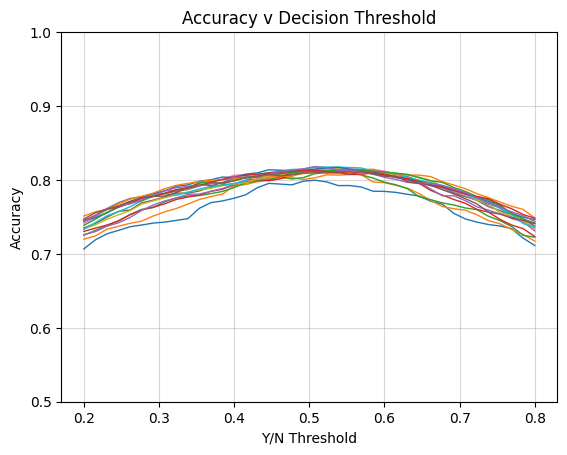

In [105]:
fig,ax=plt.subplots()
for i_lr, lr in enumerate(learning_rates):
    for i_d, d in enumerate(depths):
        run=metrics_by_lr[i_lr, i_d].T[1]
        roc=metrics_by_lr[i_lr, i_d].T[0]
        #ll=metrics_by_lr[i_lr, i_d].T[2]
        ax.plot(thresholds, run, label=f"lr={lr}, depth={d}", linestyle="-", linewidth=1)
        #ax.plot(thresholds, ll, label=f"lr={lr}, depth={d}", linestyle="--", linewidth=1)
        print(f"acc={run.max():.5f}, f1_score={metrics_by_lr[i_lr, i_d].T[3][np.argmax(run)]:.4f}, log_loss={metrics_by_lr[i_lr, i_d].T[2][np.argmax(run)]:.4f}, [d={d}, lr={lr}, t={thresholds[np.argmax(run)]:.2f}]")
ax.set_xlabel("Y/N Threshold")
ax.set_ylabel("Accuracy")
ax.set_ylim([0.5,1])
ax.grid(alpha=0.5)
ax.set_title("Accuracy v Decision Threshold")


In [415]:
# Prepare training data -> split training set into (70% / 15% / 15%) #
X=data.drop(columns=["Id","FreePass", "AvgTime", 'FoodRate', 'DrinkRate','Ticket_Type', 'isAdult',
                     'Food', 'Drinks', 'VIP', 'Concert_Duration', 'logFood'])
Y=data["FreePass"]
IDs=data["Id"]

data_test_IDs = data_test["Id"]
X_test_ext = data_test.drop(columns=["Id", "AvgTime", 'FoodRate', 'DrinkRate','Ticket_Type','isAdult',
                     'Food', 'Drinks', 'VIP', 'Concert_Duration', 'logFood'])

# 100 -> 70/30 #
X_train, X_hold, Y_train, Y_hold, ID_train, ID_hold = train_test_split(
    X,Y,IDs,
    test_size=0.3,
    random_state=randstate,
    stratify=Y
)

# 30 -> 15/15 #
X_val, X_test, Y_val, Y_test, ID_val, ID_test = train_test_split(
    X_hold,Y_hold,ID_hold,
    test_size=0.5,
    random_state=randstate2,
    stratify=Y_hold
)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=np.random.randint(0,1000))


In [416]:
model_baseline = LogisticRegression(max_iter=2000)

baseline_score = cross_val_score(
    model_baseline, X, Y, cv=5, scoring='roc_auc'
).mean()

baseline_score

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/peterclark/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/peterclark/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1138, in fit
    X, y = self._validate_data(
  File "/Users/peterclark/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/base.py", line 596, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/Users/peterclark/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/utils/validation.py", line 1074, in check_X_y
    X = check_array(
  File "/Users/peterclark/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/utils/validation.py", line 791, in check_array
    array = array.astype(new_dtype)
  File "/Users/peterclark/opt/anaconda3/envs/main/lib/python3.10/site-packages/pandas/core/generic.py", line 5912, in astype
    new_data = self._mgr.astype(dtype=dtype, copy=copy, errors=errors)
  File "/Users/peterclark/opt/anaconda3/envs/main/lib/python3.10/site-packages/pandas/core/internals/managers.py", line 419, in astype
    return self.apply("astype", dtype=dtype, copy=copy, errors=errors)
  File "/Users/peterclark/opt/anaconda3/envs/main/lib/python3.10/site-packages/pandas/core/internals/managers.py", line 304, in apply
    applied = getattr(b, f)(**kwargs)
  File "/Users/peterclark/opt/anaconda3/envs/main/lib/python3.10/site-packages/pandas/core/internals/blocks.py", line 580, in astype
    new_values = astype_array_safe(values, dtype, copy=copy, errors=errors)
  File "/Users/peterclark/opt/anaconda3/envs/main/lib/python3.10/site-packages/pandas/core/dtypes/cast.py", line 1292, in astype_array_safe
    new_values = astype_array(values, dtype, copy=copy)
  File "/Users/peterclark/opt/anaconda3/envs/main/lib/python3.10/site-packages/pandas/core/dtypes/cast.py", line 1237, in astype_array
    values = astype_nansafe(values, dtype, copy=copy)
  File "/Users/peterclark/opt/anaconda3/envs/main/lib/python3.10/site-packages/pandas/core/dtypes/cast.py", line 1098, in astype_nansafe
    result = astype_nansafe(flat, dtype, copy=copy, skipna=skipna)
  File "/Users/peterclark/opt/anaconda3/envs/main/lib/python3.10/site-packages/pandas/core/dtypes/cast.py", line 1181, in astype_nansafe
    return arr.astype(dtype, copy=True)
ValueError: could not convert string to float: 'Head Hunters'


In [407]:

rf.fit(X,Y)

importances = pd.Series(
    rf.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

importances.head(15)

r = permutation_importance(
    rf, X, Y,
    n_repeats=10,
    random_state=42,
    scoring='roc_auc'
)

perm = pd.Series(
    r.importances_mean,
    index=X.columns
).sort_values(ascending=False)

perm

logDrinks                     0.085274
Vinyl_True                    0.042882
PreferedAlbum_Kind of Blue    0.040589
PreferedAlbum_Head Hunters    0.026659
Ticket_Num                    0.025109
consumeF                      0.015744
Ticket_Class_XL               0.013985
Age                           0.010106
Opinion_Polarity              0.010010
consumeD                      0.007179
Concert_City_NYC              0.007144
Concert_City_SF               0.001462
dtype: float64

In [381]:
from sklearn.feature_selection import RFECV

selector = RFECV(
    estimator=LogisticRegression(max_iter=2000),
    step=1,
    cv=5,
    scoring='roc_auc'
)

selector.fit(X, Y)

selected_features = X.columns[selector.support_]
selected_features


Index(['Age', 'consumeF', 'consumeD', 'Ticket_Num',
       'PreferedAlbum_Head Hunters', 'PreferedAlbum_Kind of Blue',
       'Vinyl_True', 'Concert_City_NYC', 'Ticket_Class_XL'],
      dtype='object')

In [211]:
X_reduced = X[selected_features]

reduced_score = cross_val_score(
    LogisticRegression(max_iter=2000),
    X_reduced, Y,
    cv=5, scoring='roc_auc'
).mean()

baseline_score, reduced_score


(0.8634161552124844, 0.8623510954066995)

In [417]:
pipelines = [logistic_l1, grad_boost_tree, elastic_log, rf]
model_names = ["logistic_l1", "grad_boost_tree", "elastic_log", "rf", "dummy_model"]
models=[]
models_cv=[]

# Train models #
for ppl in pipelines:
    models.append(train_model(ppl, X_train, Y_train))
dummy_answers = Y_train.sample(frac=1.0, random_state=55).values
dummy_model = train_model(dlog_l1, X_train, dummy_answers)
models.append(dummy_model)

thresholds=np.linspace(0.2, 0.8, 40)

# Evaluate with validation split
metrics_all_val = []
for _,m in enumerate(models):
    metrics_model=[]
    print(f"----------- ({str(model_names[_])})")
    for t in thresholds:
        scores,output,metrics = eval_model(m, X_val, Y_val, t)
        metrics_model.append(metrics)
    metrics_all_val.append(metrics_model)

metrics_all = []
for _,m in enumerate(models):
    metrics_model=[]
    print(f"----------- ({str(model_names[_])})")
    for t in thresholds:
        scores,output,metrics = eval_model(m, X_test, Y_test, t)
        metrics_model.append(metrics)
    metrics_all.append(metrics_model)


ValueError: could not convert string to float: 'Bright Size Life'

In [ ]:
pipelines = [logistic_l1, grad_boost_tree, elastic_log, rf]
model_names = ["logistic_l1", "grad_boost_tree", "elastic_log", "rf", "dummy_model"]
models=[]
models_cv=[]


# Train models #
for ppl in pipelines:
    models.append(train_model(ppl, X_train, Y_train))
dummy_answers = Y_train.sample(frac=1.0, random_state=55).values
dummy_model = train_model(dlog_l1, X_train, dummy_answers)
models.append(dummy_model)
models_cv.append(models)
thresholds=np.linspace(0.2, 0.8, 40)

# Evaluate with validation split
metrics_all_val = []
for _,m in enumerate(models):
    metrics_model=[]
    print(f"----------- ({str(model_names[_])})")
    for t in thresholds:
        scores,output,metrics = eval_model(m, X_val, Y_val, t)
        metrics_model.append(metrics)
    metrics_all_val.append(metrics_model)

metrics_all = []
for _,m in enumerate(models):
    metrics_model=[]
    print(f"----------- ({str(model_names[_])})")
    for t in thresholds:
        scores,output,metrics = eval_model(m, X_test, Y_test, t)
        metrics_model.append(metrics)
    metrics_all.append(metrics_model)


Validation: 
0.7885(th=0.55) -- logistic_l1
0.8111(th=0.52) -- grad_boost_tree
0.7876(th=0.55) -- elastic_log
0.8120(th=0.52) -- rf
0.5144(th=0.20) -- dummy_model
Test: 
0.7852(th=0.42) -- logistic_l1
0.8043(th=0.51) -- grad_boost_tree
0.7835(th=0.38) -- elastic_log
0.8061(th=0.46) -- rf
0.5148(th=0.20) -- dummy_model


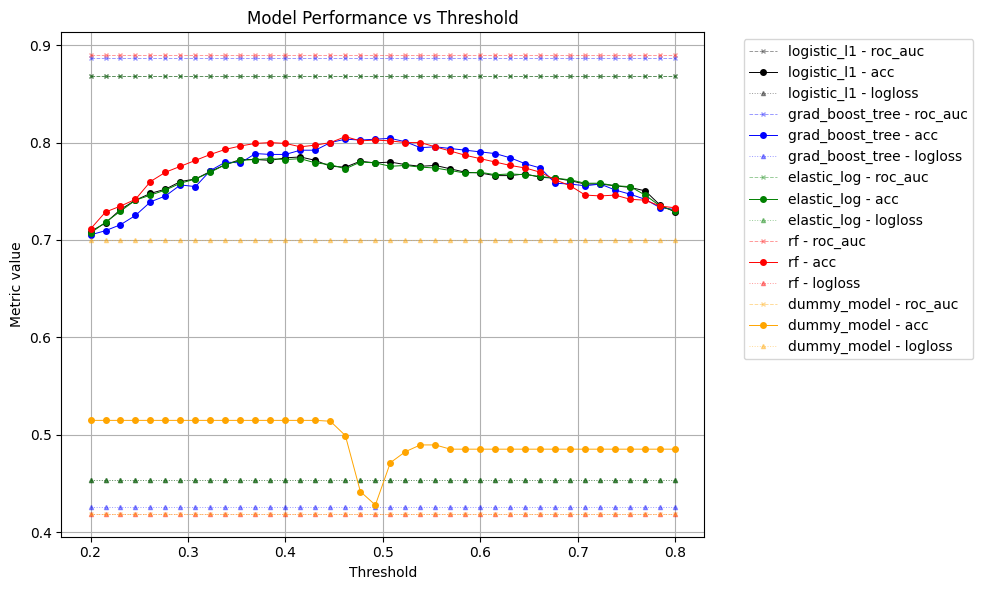

In [409]:
plot_metrics_val = []
for _m, m in enumerate(metrics_all_val):
    acc=[]
    roc=[]
    logloss=[]
    for _t, t in enumerate(metrics_all_val[_m]):
        #print(t)
        roc.append(t[0])
        acc.append(t[1])
        logloss.append(t[2])
    roc=np.asarray(roc, dtype=float)
    acc=np.asarray(acc, dtype=float)
    logloss=np.asarray(logloss, dtype=float)
    plot_metrics_val.append([roc, acc, logloss])
plot_metrics_val=np.asarray(plot_metrics_val)
print("Validation: ")
for _, mdl in enumerate(plot_metrics_val):
    print(f"{np.max(plot_metrics_val[_,1,:]):.4f}(th={thresholds[np.argmax(plot_metrics_val[_,1,:])]:.2f}) -- {model_names[_]}")

plot_metrics = []
for _m, m in enumerate(metrics_all):
    acc=[]
    roc=[]
    logloss=[]
    for _t, t in enumerate(metrics_all[_m]):
        #print(t)
        roc.append(t[0])
        acc.append(t[1])
        logloss.append(t[2])
    roc=np.asarray(roc, dtype=float)
    acc=np.asarray(acc, dtype=float)
    logloss=np.asarray(logloss, dtype=float)
    plot_metrics.append([roc, acc, logloss])
plot_metrics=np.asarray(plot_metrics)

print("Test: ")
for _, mdl in enumerate(plot_metrics):
    print(f"{np.max(plot_metrics[_,1,:]):.4f}(th={thresholds[np.argmax(plot_metrics[_,1,:])]:.2f}) -- {model_names[_]}")


plot_metrics_names = ["roc_auc", "acc", "logloss"]

plt.figure(figsize=(10, 6))
colors=['black', 'blue', 'green', 'red', 'orange']
markers = ["x",".","^"]
linestyles=['--','-',':']
markersizes=[3,8,3]
alphas=[0.4,1,0.4]
# Loop over models
for i, model in enumerate(plot_metrics):
    # Select only this model's rows
    
    # Plot each metric for this model
    for n, mtrc in enumerate(plot_metrics_names):
        plt.plot(
            thresholds,
            plot_metrics[i][n],
            marker=markers[n],
            markersize=markersizes[n],
            linewidth=0.7,
            color=colors[i],
            alpha=alphas[n],
            linestyle=linestyles[n],
            label=f"{model_names[i]} - {mtrc}"
        )

plt.title("Model Performance vs Threshold")
plt.xlabel("Threshold")
plt.ylabel("Metric value")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

In [248]:
model_cat

HistGradientBoostingClassifier(categorical_features=[0, 1, 5, 6, 8],
                               early_stopping=True, learning_rate=0.05,
                               max_depth=5, max_iter=300, random_state=521)

In [249]:
#output= models[1].predict(X_test_ext)
output2= model_cat.predict(X_test_ext)
#output_pred = output >= 0.40
output_pred2 = output2 >= 0.51
""" output_df = (
    data_test_IDs
    .to_frame(name="Id")
    .assign(FreePass=output_pred)
)
output_df """

#output_df.to_csv(os.getcwd()+"/results/logistic_regression-Alex_Peter-JAN18.csv", index=False)
output_df2 = (
    data_test_IDs
    .to_frame(name="Id")
    .assign(FreePass=output_pred2)
)


output_df2.to_csv(os.getcwd()+"/results/gradboosttree-Alex_Peter-JAN18-2.csv", index=False)
output_df2.shape

(2854, 2)